# This is an R notebook!

In [12]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(tidyr)
library(tibble)
library(Matrix)
library(patchwork)

# Dataset level comparison

In [ ]:
# Function to generate expr_df from 10X paths
make_expr_df <- function(all_dir, filtered_dir) {
  all_counts <- Read10X(data.dir = all_dir)
  filtered_counts <- Read10X(data.dir = filtered_dir)

  all_expr <- Matrix::rowSums(all_counts)
  filtered_expr <- Matrix::rowSums(filtered_counts)

  full_join(
    data.frame(isoform = names(all_expr), all_expr = all_expr),
    data.frame(isoform = names(filtered_expr), filtered_expr = filtered_expr),
    by = "isoform"
  ) %>%
    mutate(
      all_expr = replace_na(all_expr, 0),
      filtered_expr = replace_na(filtered_expr, 0),
      ratio = ifelse(all_expr == 0, NA, 1- (filtered_expr / all_expr)),
      bin = case_when(
        is.na(ratio) ~ "NA",
        ratio < 0.2 ~ "<20%",
        ratio < 0.8 ~ "20–80%",
        TRUE ~ ">80%"
      )
    )
}

In [ ]:
compute_bin_counts <- function(de_file, expr_df, label, group_label) {
  de_df <- read.table(de_file, header = TRUE) %>%
    rename(isoform = gene)

  expr_df %>%
    semi_join(de_df, by = "isoform") %>%
    count(bin) %>%
    mutate(dataset = label, group = group_label)
}

In [ ]:
# finding the same path as generated by the Python notebook
home <- path.expand("~")
data_path <- file.path(home, "data")
de_path <- file.path(data_path, "DE_analysis")
de_path <- normalizePath(de_path, mustWork = FALSE)

In [ ]:
# === Dataset 1: 10X 3p ===
expr_df_3p <- make_expr_df(
  file.path(de_path, "10x_3'_allisoform_reconstructed_dedup"),
  file.path(de_path, "10x_3'_goodpriming_reconstructed_dedup")
)

df_3p_all <- compute_bin_counts(
  file.path(de_path, "10X_3p_reconstructed_allisoform_dedup.isoforms_seurat-filtered_marker_isoforms.tsv"),
  expr_df_3p,
  "10X 3p all",
  group_label = "10X 3p"
)

df_3p_filtered <- compute_bin_counts(
  file.path(de_path, "10X_3p_reconstructed_goodpriming_dedup.isoforms_seurat-filtered_marker_isoforms.tsv"),
  expr_df_3p,
  "10X 3p filtered",
  group_label = "10X 3p"
)
print("Done with 10X 3p")

# === Dataset 2: 10X 5p ===
expr_df_5p <- make_expr_df(
  file.path(de_path, "10x_5'_allisoform_reconstructed_dedup"),
  file.path(de_path, "10x_5'_goodpriming_reconstructed_dedup")
)

df_5p_all <- compute_bin_counts(
  file.path(de_path, "10X_5p_reconstructed_allisoform_dedup.isoforms_seurat-filtered_marker_isoforms.tsv"),
  expr_df_5p,
  "10X 5p all",
  group_label = "10X 5p"
)

df_5p_filtered <- compute_bin_counts(
  file.path(de_path, "10X_5p_reconstructed_goodpriming_dedup.isoforms_seurat-filtered_marker_isoforms.tsv"),
  expr_df_5p,
  "10X 5p filtered",
  group_label = "10X 5p"
)
print("Done with 10X 5p")

# === Dataset 3: PIPseq 0.8x ===
expr_df_pip <- make_expr_df(
  file.path(de_path, "PIPseq_0.8x_allisoform_reconstructed_dedup"),
  file.path(de_path, "PIPseq_0.8x_goodpriming_reconstructed_dedup")
)

df_pip_all <- compute_bin_counts(
  file.path(de_path, "PIPseq_0.8x_reconstructed_allisoform_dedup.isoforms_seurat-filtered_marker_isoforms.tsv"),
  expr_df_pip,
  "PIPseq 0.8x all",
  group_label = "PIPseq 0.8x"
)

df_pip_filtered <- compute_bin_counts(
  file.path(de_path, "PIPseq_0.8x_reconstructed_goodpriming_dedup.isoforms_seurat-filtered_marker_isoforms.tsv"),
  expr_df_pip,
  "PIPseq 0.8x filtered",
  group_label = "PIPseq 0.8x"
)
print("Done with PIPseq 0.8x")


In [ ]:
# Combine all
plot_df_combined <- bind_rows(
  df_3p_all, df_3p_filtered,
  df_5p_all, df_5p_filtered,
  df_pip_all, df_pip_filtered
)

# Clean up factor levels
plot_df_combined$bin <- factor(plot_df_combined$bin, levels = c( ">80%", "20–80%", "<20%"))
plot_df_combined$dataset <- factor(
  plot_df_combined$dataset,
  levels = c("10X 3p all", "10X 3p filtered", "10X 5p all", "10X 5p filtered", "PIPseq 0.8x all", "PIPseq 0.8x filtered")
)


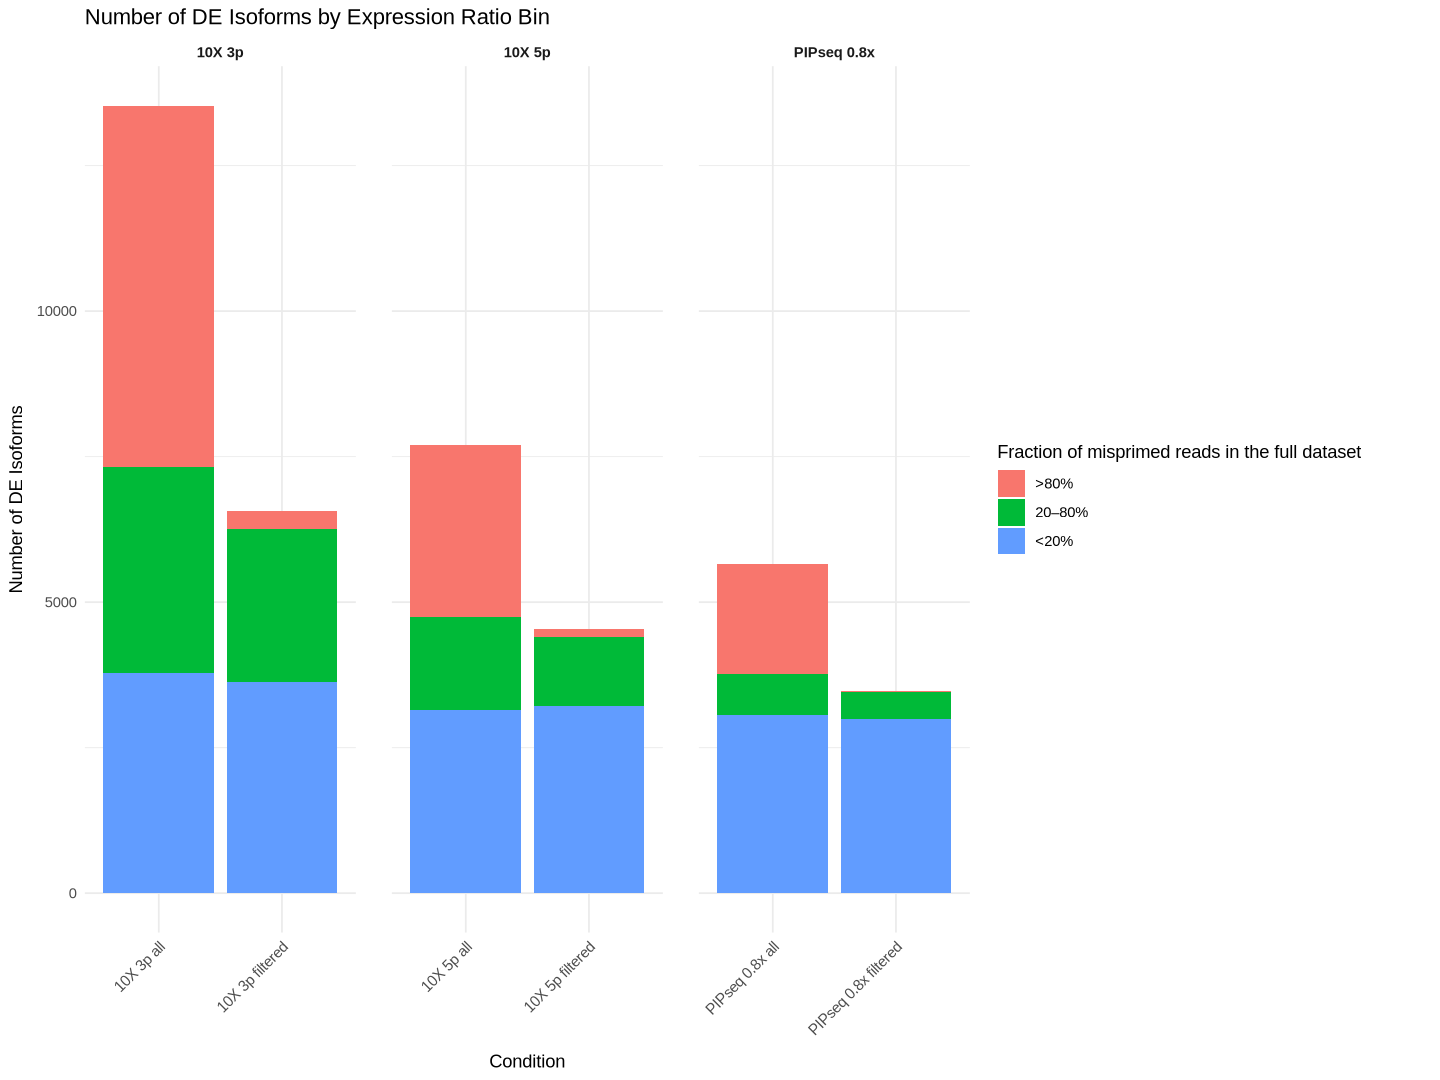

In [14]:
p <- ggplot(plot_df_combined, aes(x = dataset, y = n, fill = bin)) +
  geom_bar(stat = "identity", position = "stack") +
  facet_grid(. ~ group, scales = "free_x", space = "free") +
  labs(
    title = "Number of DE Isoforms by Expression Ratio Bin",
    x = "Condition",
    y = "Number of DE Isoforms",
    fill = "Fraction of misprimed reads in the full dataset"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    strip.text = element_text(face = "bold"),
    panel.spacing.x = unit(1.5, "lines")
  )

# Optional: show bigger in notebooks
options(repr.plot.width = 12, repr.plot.height = 9)
print(p)

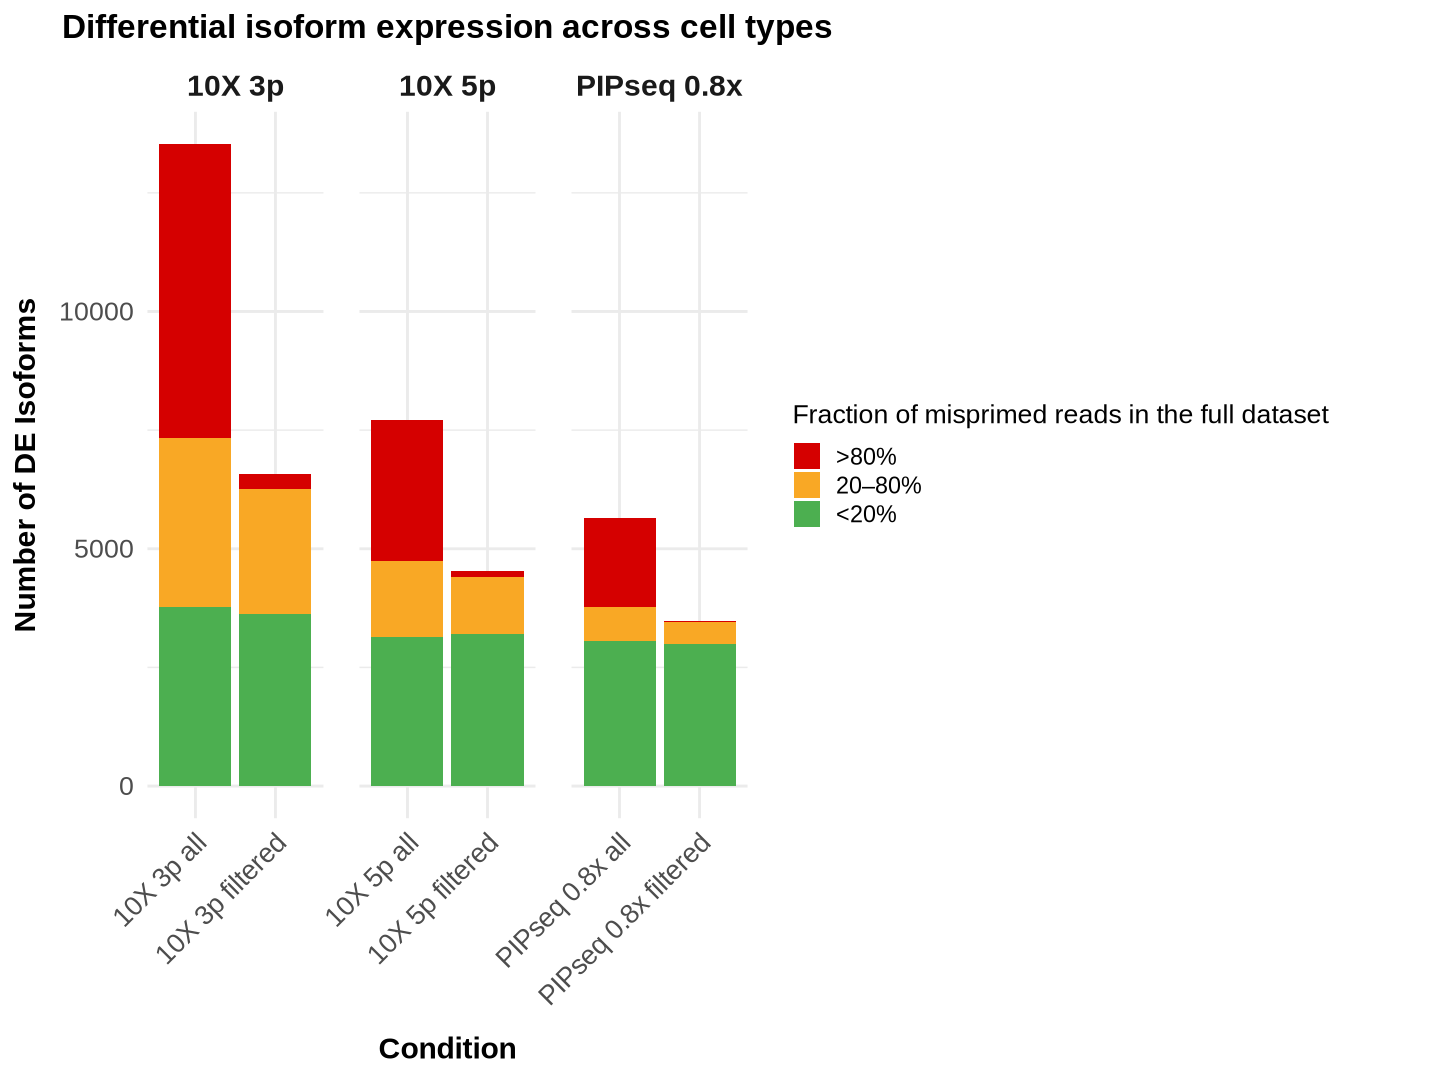

In [13]:
p <- ggplot(plot_df_combined, aes(x = dataset, y = n, fill = bin)) +
  geom_bar(stat = "identity", position = "stack") +
  facet_grid(. ~ group, scales = "free_x", space = "free") +
  labs(
    title = "Differential isoform expression across cell types",
    x = "Condition",
    y = "Number of DE Isoforms",
    fill = "Fraction of misprimed reads in the full dataset"
  ) +
  scale_fill_manual(values = c("<20%" = "#4CAF50", "20–80%" = "#F9A825", ">80%" = "#D50000")) +
  theme_minimal(base_size = 18) +  # base font size
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 16),
    axis.text.y = element_text(size = 16),
    axis.title = element_text(size = 18, face = "bold"),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14),
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
    strip.text = element_text(size = 18, face = "bold"),
    panel.spacing.x = unit(1.5, "lines"),
    theme(text = element_text(family = "sans"))
  )

# Optional: show bigger in notebooks
options(repr.plot.width = 12, repr.plot.height = 9)
print(p)

In [ ]:
ggsave(file.path(de_path, "de_isoforms_barplot.svg"), plot = p, width = 12, height = 9)

In [15]:
pct_over80 <- plot_df_combined %>%
  filter(grepl(" all$", dataset)) %>%           # keep only the “all” versions
  group_by(group) %>%                           # one result per library
  summarise(
    total = sum(n, na.rm = TRUE),
    over80 = sum(n[bin == ">80%"], na.rm = TRUE),
    pct_over80 = over80 / total
  ) %>%
  arrange(match(group, c("10X 3p", "10X 5p", "PIPseq 0.8x"))) %>%
  mutate(pct_label = sprintf("%.1f%%", 100 * pct_over80))

pct_over80

group,total,over80,pct_over80,pct_label
<chr>,<int>,<int>,<dbl>,<chr>
10X 3p,13531,6205,0.4585766,45.9%
10X 5p,7708,2956,0.3834977,38.3%
PIPseq 0.8x,5647,1883,0.3334514,33.3%


# Per cluster comparison

We will now look at the top 20 isoforms that are differentially expressed per cluster. For each cluster, we have the top 20 calculated over the unfiltered data, and the top 20 calculated over the good priming reads only. This way, we can then compare how many isoforms that are found to be DE are primarily supported by misprimed reads when the data is unfiltered, and how many of the isoforms that are DE even when looking at the filtered data still have a significant fraction of misprimed reads.

## Intra-Cluster mispriming rates

In this section, we will calculate mispriming rates as only the fraction of misprimed reads within the cell type cluster where the isoform is differentially expressed.

In [ ]:
cluster_labels_df <- bind_rows(
  tibble(dataset = "10X 3p", cluster = 0:7, cluster_label = c(
    'CD4 T cells 1', 'CD4 T cells 2', 'Naive CD4', 'Cytotoxic T cells',
    'B cells', 'CD14 Monocytes', 'CD16 Monocytes', 'DC'
  )),
  tibble(dataset = "10X 5p", cluster = 0:7, cluster_label = c(
    'CD4 T cells 1', 'CD4 T cells 2', 'Naive CD4', 'Cytotoxic T cells',
    'Innate Lymphoid', 'B cells', 'CD14 Monocytes', 'CD16 Monocytes'
  )),
  tibble(dataset = "PIPseq 0.8x", cluster = 0:7, cluster_label = c(
    'CD4 T cells 1', 'CD4 T cells 2', 'Naive CD4', 'Cytotoxic T cells',
    'Innate Lymphoid', 'CD16 Monocytes', 'CD14 Monocytes', 'B cells'
  ))
)

In [ ]:
compute_expr_per_isoform_per_cluster <- function(all_counts, filtered_counts, cluster_df) {


  # Helper: get expression per isoform per cluster from a sparse matrix
  summarize_expr <- function(mat, cluster_df) {
    mat <- mat[, colnames(mat) %in% cluster_df$cell, drop = FALSE]

    # Sparse representation of non-zero entries
    df <- Matrix::summary(mat)  # gives i, j, x

    tibble(
      isoform = rownames(mat)[df$i],
      barcode = colnames(mat)[df$j],
      count = df$x
    ) %>%
      inner_join(cluster_df, by = c("barcode" = "cell")) %>%
      group_by(isoform, cluster) %>%
      summarise(expr = sum(count), .groups = "drop")
  }

  all_expr <- summarize_expr(all_counts, cluster_df) %>%
    rename(all_expr = expr)

  filtered_expr <- summarize_expr(filtered_counts, cluster_df) %>%
    rename(filtered_expr = expr)

  # Merge safely and fill missing values
  full_join(all_expr, filtered_expr, by = c("isoform", "cluster")) %>%
    mutate(
      all_expr = replace_na(all_expr, 0),
      filtered_expr = replace_na(filtered_expr, 0)
    )
}


In [ ]:
compute_bin_counts_top20 <- function(top20_file, expr_df, condition_label, dataset_label) {
  top20 <- read.table(top20_file, header = TRUE) %>%
    rename(isoform = gene) %>%
    filter(cluster != -1)

  df <- inner_join(top20, expr_df, by = c("isoform", "cluster")) %>%
    mutate(
      ratio = ifelse(all_expr == 0, NA, 1 - (filtered_expr / all_expr)),
      bin = case_when(
        is.na(ratio) ~ "NA",
        ratio < 0.2 ~ "<20%",
        ratio < 0.8 ~ "20–80%",
        TRUE ~ ">80%"
      ),
      condition = condition_label,
      dataset = dataset_label
    ) %>%
    count(cluster, bin, condition, dataset)

  return(df)
}


In [ ]:
# Load once
all_counts_3p      <- Read10X(file.path(de_path, "10x_3'_allisoform_reconstructed_dedup"))
filtered_counts_3p <- Read10X(file.path(de_path, "10x_3'_goodpriming_reconstructed_dedup"))
clusters_3p        <- read.csv(file.path(de_path, "10x_3'_allisoform_reconstructed_dedup", "cell_clusters.csv"))

# Precompute expression table
expr_df_percluster_3p <- compute_expr_per_isoform_per_cluster(all_counts_3p, filtered_counts_3p, clusters_3p)

# Top 20 DE bin counts
df_3p_percluster_all <- compute_bin_counts_top20(
  top20_file      = file.path(de_path, "10X_3p_reconstructed_allisoform_dedup.isoforms_seurat-top20_filtered_marker_isoforms.tsv"),
  expr_df         = expr_df_percluster_3p,
  condition_label = "all",
  dataset_label   = "10X 3p"
)

df_3p_percluster_filtered <- compute_bin_counts_top20(
  top20_file      = file.path(de_path, "10X_3p_reconstructed_goodpriming_dedup.isoforms_seurat-top20_filtered_marker_isoforms.tsv"),
  expr_df         = expr_df_percluster_3p,
  condition_label = "filtered",
  dataset_label   = "10X 3p"
)
print("Done with 10X 3p")

# 10X 5p
all_counts_5p      <- Read10X(file.path(de_path, "10x_5'_allisoform_reconstructed_dedup"))
filtered_counts_5p <- Read10X(file.path(de_path, "10x_5'_goodpriming_reconstructed_dedup"))
clusters_5p        <- read.csv(file.path(de_path, "10x_5'_allisoform_reconstructed_dedup", "cell_clusters.csv"))

expr_df_percluster_5p <- compute_expr_per_isoform_per_cluster(all_counts_5p, filtered_counts_5p, clusters_5p)

df_5p_percluster_all <- compute_bin_counts_top20(
  top20_file      = file.path(de_path, "10X_5p_reconstructed_allisoform_dedup.isoforms_seurat-top20_filtered_marker_isoforms.tsv"),
  expr_df         = expr_df_percluster_5p,
  condition_label = "all",
  dataset_label   = "10X 5p"
)

df_5p_percluster_filtered <- compute_bin_counts_top20(
  top20_file      = file.path(de_path, "10X_5p_reconstructed_goodpriming_dedup.isoforms_seurat-top20_filtered_marker_isoforms.tsv"),
  expr_df         = expr_df_percluster_5p,
  condition_label = "filtered",
  dataset_label   = "10X 5p"
)
print("Done with 10X 5p")

# PIPseq 0.8x
all_counts_pip      <- Read10X(file.path(de_path, "PIPseq_0.8x_allisoform_reconstructed_dedup"))
filtered_counts_pip <- Read10X(file.path(de_path, "PIPseq_0.8x_goodpriming_reconstructed_dedup"))
clusters_pip        <- read.csv(file.path(de_path, "PIPseq_0.8x_allisoform_reconstructed_dedup", "cell_clusters.csv"))

expr_df_percluster_pip <- compute_expr_per_isoform_per_cluster(all_counts_pip, filtered_counts_pip, clusters_pip)

df_pip_percluster_all <- compute_bin_counts_top20(
  top20_file      = file.path(de_path, "PIPseq_0.8x_reconstructed_allisoform_dedup.isoforms_seurat-top20_filtered_marker_isoforms.tsv"),
  expr_df         = expr_df_percluster_pip,
  condition_label = "all",
  dataset_label   = "PIPseq 0.8x"
)

df_pip_percluster_filtered <- compute_bin_counts_top20(
  top20_file      = file.path(de_path, "PIPseq_0.8x_reconstructed_goodpriming_dedup.isoforms_seurat-top20_filtered_marker_isoforms.tsv"),
  expr_df         = expr_df_percluster_pip,
  condition_label = "filtered",
  dataset_label   = "PIPseq 0.8x"
)
print("Done with PIPseq 0.8x")

In [ ]:
plot_df_percluster_top20 <- bind_rows(
  df_3p_percluster_all, df_3p_percluster_filtered,
  df_5p_percluster_all, df_5p_percluster_filtered,
  df_pip_percluster_all, df_pip_percluster_filtered
)

plot_df_percluster_top20$bin <- factor(plot_df_percluster_top20$bin, levels = c(">80%", "20–80%", "<20%"))

plot_df_percluster_top20 <- plot_df_percluster_top20 %>%
  left_join(cluster_labels_df, by = c("dataset", "cluster"))


In [ ]:
# Attach cell-type labels
plot_df_percluster_top20 <- plot_df_percluster_top20 %>%
  mutate(
    cluster = as.factor(cluster),
    condition = factor(condition, levels = c("all", "filtered")),
    dataset = factor(dataset),
    cluster_id = as.integer(as.character(cluster)),  # for spacing
    group_index = cluster_id * 3 + as.integer(condition) - 1       # spacing + pairing
  )

# Filter per dataset
plot_df_3p  <- plot_df_percluster_top20 %>% filter(dataset == "10X 3p")
plot_df_5p  <- plot_df_percluster_top20 %>% filter(dataset == "10X 5p")
plot_df_pip <- plot_df_percluster_top20 %>% filter(dataset == "PIPseq 0.8x")

x_labels_3p <- plot_df_3p %>% filter(condition == "all") %>%
  distinct(group_index, cluster_label) %>% arrange(group_index) %>%
  rename(label = cluster_label)

x_labels_5p <- plot_df_5p %>% filter(condition == "all") %>%
  distinct(group_index, cluster_label) %>% arrange(group_index) %>%
  rename(label = cluster_label)

x_labels_pip <- plot_df_pip %>% filter(condition == "all") %>%
  distinct(group_index, cluster_label) %>% arrange(group_index) %>%
  rename(label = cluster_label)

# Create condition label data frame
condition_labels <- plot_df_percluster_top20 %>%
  distinct(dataset, condition, cluster, group_index) %>%
  mutate(label = ifelse(condition == "all", "NF", "F"))

plot_dataset <- function(df, x_labels, title) {
  ggplot(df, aes(x = group_index, y = n, fill = bin)) +
    geom_bar(stat = "identity", position = "stack", width = 0.9) +
    geom_text(
      data = condition_labels %>% filter(dataset == title),
      aes(x = group_index, y = -1, label = label),  # below bars
      inherit.aes = FALSE,
      size = 5,
      fontface = "bold"
    ) +
    scale_x_continuous(
      breaks = x_labels$group_index,
      labels = x_labels$label,
      expand = expansion(mult = c(0.01, 0.05))
    ) +
    labs(
      title = title,
      x = "Cluster",
      y = "Number of DE Isoforms",
      fill = "Fraction of misprimed reads"
    ) +
    scale_fill_manual(values = c("<20%" = "#4CAF50", "20–80%" = "#F9A825", ">80%" = "#D50000")) +
    theme_minimal(base_size = 16) +
    theme(
      axis.text.x = element_text(angle = 60, hjust = 0.5, vjust = 0.5, size = 16),
      axis.text.y = element_text(size = 16),
      axis.title  = element_text(size = 18, face = "bold"),
      legend.title= element_text(size = 16),
      legend.text = element_text(size = 14),
      plot.title  = element_text(size = 20, face = "bold", hjust = 0.5),
      strip.text  = element_text(size = 18, face = "bold"),
      panel.spacing.x = unit(1.5, "lines"),
      text = element_text(family = "sans"),
      legend.position = "none"
    )
}

# Compose with patchwork
p2 <-
  plot_dataset(plot_df_3p,  x_labels_3p,  "10X 3p") /
  plot_dataset(plot_df_5p,  x_labels_5p,  "10X 5p") /
  plot_dataset(plot_df_pip, x_labels_pip, "PIPseq 0.8x") +
  plot_layout(guides = "collect") &
  theme(legend.position = "right")

options(repr.plot.width = 12, repr.plot.height = 15)
print(p2)


In [ ]:
ggsave(file.path(de_path, "de_isoforms_per_cluster_ratio_barplot.pdf"), plot = p2, width = 12, height = 9, device = cairo_pdf)

## Dataset wide mispriming rates 

In this section, we will instead calculate the mispriming rates as the fraction of misprimed reads across all cells, while still looking at the top 20 differentially expressed isoforms per cluster.

In [ ]:
compute_bin_counts_top20_from_expr <- function(top20_file, cluster_df, expr_df, condition_label, dataset_label) {
  top20 <- read.table(top20_file, header = TRUE) %>%
    rename(isoform = gene) %>%
    filter(cluster != -1)

  # Join full-dataset ratio onto isoform+cluster assignment from DE
  df <- top20 %>%
    inner_join(expr_df[, c("isoform", "bin")], by = "isoform") %>%
    mutate(
      condition = condition_label,
      dataset = dataset_label
    ) %>%
    count(cluster, bin, condition, dataset)

  return(df)
}


In [ ]:
compute_bin_counts_top20_global_ratio <- function(top20_file, global_expr_df, condition_label, dataset_label) {
  top20 <- read.table(top20_file, header = TRUE) %>%
    rename(isoform = gene) %>%
    filter(cluster != -1)

  top20 %>%
    inner_join(global_expr_df[, c("isoform", "bin")], by = "isoform") %>%
    count(cluster, bin) %>%
    mutate(condition = condition_label, dataset = dataset_label)
}


In [ ]:
# Global expression
expr_df_3p <- make_expr_df(
  file.path(de_path, "10x_3'_allisoform_reconstructed_dedup"),
  file.path(de_path, "10x_3'_goodpriming_reconstructed_dedup")
)

# Top 20 per cluster, but use global binning
df_3p_all <- compute_bin_counts_top20_global_ratio(
  top20_file     = file.path(de_path, "10X_3p_reconstructed_allisoform_dedup.isoforms_seurat-top20_filtered_marker_isoforms.tsv"),
  global_expr_df = expr_df_3p,
  condition_label= "all",
  dataset_label  = "10X 3p"
)

df_3p_filtered <- compute_bin_counts_top20_global_ratio(
  top20_file     = file.path(de_path, "10X_3p_reconstructed_goodpriming_dedup.isoforms_seurat-top20_filtered_marker_isoforms.tsv"),
  global_expr_df = expr_df_3p,
  condition_label= "filtered",
  dataset_label  = "10X 3p"
)
print("Done with 10X 3p")

# 10X 5p
expr_df_5p <- make_expr_df(
  file.path(de_path, "10x_5'_allisoform_reconstructed_dedup"),
  file.path(de_path, "10x_5'_goodpriming_reconstructed_dedup")
)

df_5p_all <- compute_bin_counts_top20_global_ratio(
  top20_file     = file.path(de_path, "10X_5p_reconstructed_allisoform_dedup.isoforms_seurat-top20_filtered_marker_isoforms.tsv"),
  global_expr_df = expr_df_5p,
  condition_label= "all",
  dataset_label  = "10X 5p"
)

df_5p_filtered <- compute_bin_counts_top20_global_ratio(
  top20_file     = file.path(de_path, "10X_5p_reconstructed_goodpriming_dedup.isoforms_seurat-top20_filtered_marker_isoforms.tsv"),
  global_expr_df = expr_df_5p,
  condition_label= "filtered",
  dataset_label  = "10X 5p"
)
print("Done with 10X 5p")

# PIPseq 0.8x
expr_df_pip <- make_expr_df(
  file.path(de_path, "PIPseq_0.8x_allisoform_reconstructed_dedup"),
  file.path(de_path, "PIPseq_0.8x_goodpriming_reconstructed_dedup")
)

df_pip_all <- compute_bin_counts_top20_global_ratio(
  top20_file     = file.path(de_path, "PIPseq_0.8x_reconstructed_allisoform_dedup.isoforms_seurat-top20_filtered_marker_isoforms.tsv"),
  global_expr_df = expr_df_pip,
  condition_label= "all",
  dataset_label  = "PIPseq 0.8x"
)

df_pip_filtered <- compute_bin_counts_top20_global_ratio(
  top20_file     = file.path(de_path, "PIPseq_0.8x_reconstructed_goodpriming_dedup.isoforms_seurat-top20_filtered_marker_isoforms.tsv"),
  global_expr_df = expr_df_pip,
  condition_label= "filtered",
  dataset_label  = "PIPseq 0.8x"
)
print("Done with PIPseq 0.8x")

In [ ]:
plot_df_top20 <- bind_rows(
  df_3p_all, df_3p_filtered,
  df_5p_all, df_5p_filtered,
  df_pip_all, df_pip_filtered
)

plot_df_top20$bin <- factor(plot_df_top20$bin, levels = c(">80%", "20–80%", "<20%"))

plot_df_top20 <- plot_df_top20 %>%
  left_join(cluster_labels_df, by = c("dataset", "cluster"))

In [ ]:

plot_df_top20 <- plot_df_top20 %>%
  mutate(
    cluster = as.factor(cluster),
    condition = factor(condition, levels = c("all", "filtered")),
    dataset = factor(dataset),
    cluster_id = as.integer(as.character(cluster)),  # for spacing
    group_index = cluster_id * 3 + as.integer(condition) - 1  # spacing + pairing
  )

# Filter per dataset
plot_df_3p <- plot_df_top20 %>% filter(dataset == "10X 3p")
plot_df_5p <- plot_df_top20 %>% filter(dataset == "10X 5p")
plot_df_pip <- plot_df_top20 %>% filter(dataset == "PIPseq 0.8x")

x_labels_3p <- plot_df_3p %>% filter(condition == "all") %>%
  distinct(group_index, cluster_label) %>% arrange(group_index) %>%
  rename(label = cluster_label)

x_labels_5p <- plot_df_5p %>% filter(condition == "all") %>%
  distinct(group_index, cluster_label) %>% arrange(group_index) %>%
  rename(label = cluster_label)

x_labels_pip <- plot_df_pip %>% filter(condition == "all") %>%
  distinct(group_index, cluster_label) %>% arrange(group_index) %>%
  rename(label = cluster_label)

# Create condition label data frame
condition_labels <- plot_df_top20 %>%
  distinct(dataset, condition, cluster, group_index) %>%
  mutate(label = ifelse(condition == "all", "NF", "F"))

plot_dataset <- function(df, x_labels, title) {
  ggplot(df, aes(x = group_index, y = n, fill = bin)) +
    geom_bar(stat = "identity", position = "stack", width = 0.9) +
    geom_text(
      data = condition_labels %>% filter(dataset == title),
      aes(x = group_index, y = -1, label = label),  # y = -1 puts it below the bar
      inherit.aes = FALSE,
      size = 5,
      fontface = "bold"
    ) +
    scale_x_continuous(
      breaks = x_labels$group_index,
      labels = x_labels$label,
      expand = expansion(mult = c(0.01, 0.05))
    ) +
    labs(
      title = title,
      x = "Cluster",
      y = "Number of DE Isoforms",
      fill = "Fraction of misprimed reads"
    ) +
    scale_fill_manual(values = c("<20%" = "#4CAF50", "20–80%" = "#F9A825", ">80%" = "#D50000")) +
    theme_minimal(base_size = 16) +

    theme(
        axis.text.x = element_text(angle = 60, hjust = 0.5, vjust=0.5, size = 16),
        axis.text.y = element_text(size = 16),
        axis.title = element_text(size = 18, face = "bold"),
        legend.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
        strip.text = element_text(size = 18, face = "bold"),
        panel.spacing.x = unit(1.5, "lines"),
        theme(text = element_text(family = "sans")),
      legend.position = "none"
    )
}

# Compose with patchwork
p3 <- 
  plot_dataset(plot_df_3p, x_labels_3p, "10X 3p") /
  plot_dataset(plot_df_5p, x_labels_5p, "10X 5p") /
  plot_dataset(plot_df_pip, x_labels_pip, "PIPseq 0.8x") +
  plot_layout(guides = "collect") &
  theme(legend.position = "right")

options(repr.plot.width = 12, repr.plot.height = 15)
print(p3)


In [ ]:
ggsave(file.path(de_path, "de_isoforms_per_cluster_global_ratio_barplot.pdf"), plot = p3, width = 12, height = 15, device = cairo_pdf)